# FTIR Peak Area Software

Fourier-transform infrared spectroscopy (FTIR) is a technique commonly used to gain an insight into the chemical composition of materials. FTIR is particularily useful in analyzing asphalt binder (bitumen) due to the relative speed and ease of the measurement. FTIR makes it easy to collect large quantities of data very quickly. The collected data can later be used to train machine learning algorythms. However, the data for each sample needs to be first organized. One way of organizing data is deriving peak areas for commonly occuring peaks in the data (shown in the image below). 

- This software allows batch processing of raw FTIR data to obtain peak areas for selected peak. 
- The software further organizes the data for multiple samples into a single table saved as a CSV file.

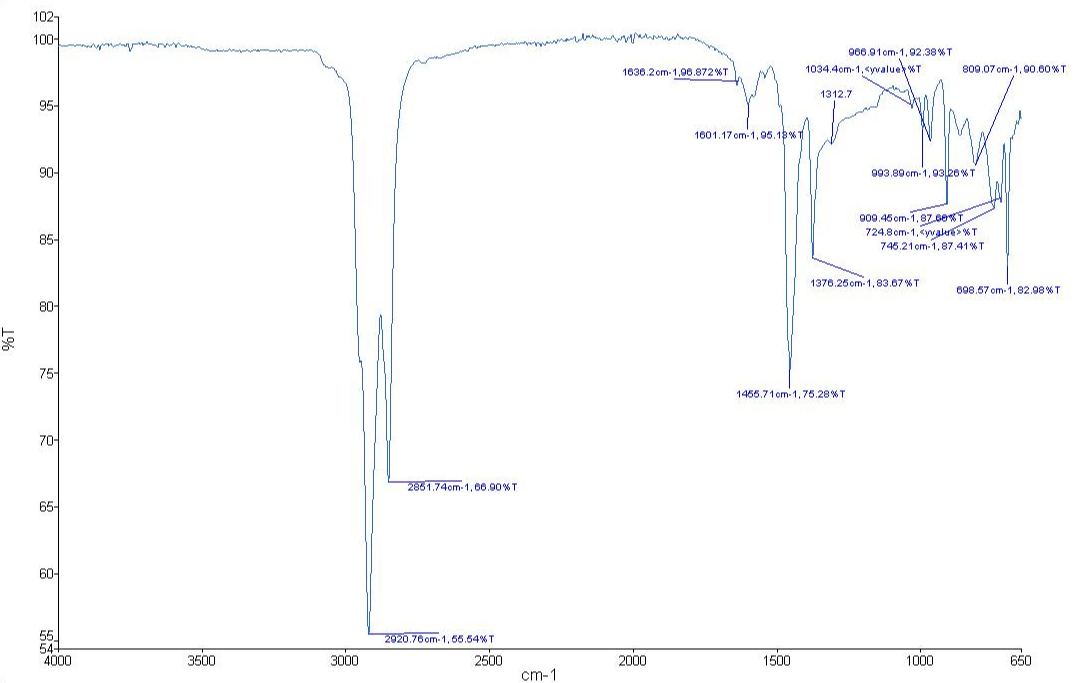

### Prerequisites:

- Create a CSV file named FTIR_sample_list and store the names of the files for analysis in column A
- Store this file in the same directory as this software 
- Example below:

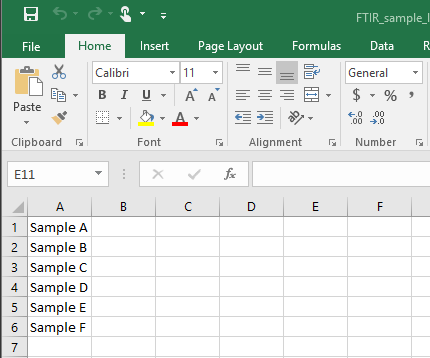

- Create a subdirectory named "FTIR Files" directly in the directory where the software is located
- Populate the directory with sample files for the analysis
- Each sample file should be in CSV format and carry the same name as that listed in the step above
- Each sample file should contain the data organized as shown below. Wavenumber in column A and % transparency in column B

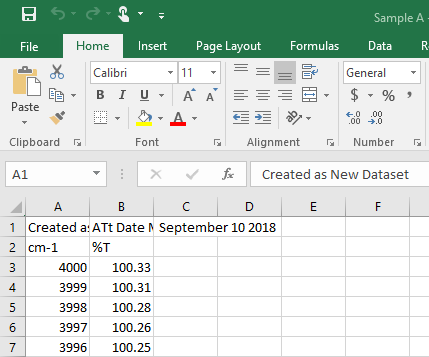

## Execution:

### Step 1: Create a peak class which:
- reads in selected file containing unique FTIR sample data
- derives peak area for the predetermined peak of interest

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

class Peak:
    def __init__(self, wavenumber_high, wavenumber_low, filename):
        """Reads a single datafile and filters according to the
        selected wavenumber band."""
        #read the data
        path = 'C:/Users/sepuchal/OneDrive - Kraton Polymers US LLC/Python/Bitumen analysis/FTIR Peak Area/FTIR Files'
        filename = filename +'.csv'
        fullpath=path+ '/' +filename
        
        data=pd.read_csv(fullpath).iloc[1:,0:2]
        data=data.rename(columns={ data.columns[0]: "wavenumber", data.columns[1]: "%T" })
        data["%T"] = data["%T"].apply(lambda x: float(x))
        data["wavenumber"] = data["wavenumber"].apply(lambda x: float(x))
        data = data[data["wavenumber"]<=wavenumber_high]
        data = data[data["wavenumber"]>=wavenumber_low]
        self.data =data      
        
    def data_setup(self):
        '''takes the data and manipulates it so that a baseline is
        created, then returns the data'''
        df=self.data.copy()
        df["wavenumber_after"] = df["wavenumber"].shift(+1)
        df["%T_after"] = df["%T"].shift(+1)
        df= df.iloc[::-1]
        #adds a step
        step = df.iloc[1,0]-df.iloc[0,0]        
        #calculates the slope:        
        y = df.iloc[-1,0]
        x = df.iloc[0,0]
        fx = df.iloc[0,1]
        fy = df.iloc[-1,1]
        self.a = (fy-fx)/(y-x)  #slope     
        #Adds a baseline:
        df =df.reset_index(drop=True).reset_index(drop=False)
        df["index"] = df["index"]
        df["baseline"] = df.iloc[0,2] + step*df["index"]*self.a
        df["baseline_after"] = df["baseline"].shift(-1)
        #Returns data
        self.data = df
        return self.data

    def slope_setup(self):
        '''Calculates the slope and returns data with slope'''
        df=self.data.iloc[:,:-2]
        df.drop_duplicates(subset ="%T", keep = 'last', inplace = True) #drop duplicate %T
        df["slope"]= (df["%T_after"]-df["%T"])/(df["wavenumber_after"]-df["wavenumber"])
        df["slope_after"] = df["slope"].shift(+1)
        df["slope_sign"] = df["slope"].apply(lambda x: np.sign(x))
        df["slope_a_sign"] = df["slope_after"].apply(lambda x: np.sign(x))
        df["slope_sum"] = abs(df["slope_sign"]+df["slope_a_sign"])
        df=df.iloc[1:-1,:]
        df["slope_change"] = df["slope_sum"].apply(lambda x: x == 2)
        df=df[df["slope_change"]==False]
        df= df["wavenumber"].values.tolist()
        self.slope_data = df       
        return self.slope_data

    def area(self):
        '''Calculates area for the indicated data'''
        df = self.data.copy().iloc[:-1,:]
        df["area_A"] = abs(df["wavenumber_after"]-df["wavenumber"])*(df["%T"]+df["%T_after"])*.5
        df["area_B"] = abs(df["wavenumber_after"]-df["wavenumber"])*(df["baseline_after"]+df["baseline"])*.5
        df["area"] = df["area_B"]-df["area_A"]
        df["area"] = df["area"][df["area"]>0] #deletes areas above the baseline
        self.total_area = (df["area"].sum())
        self.data2 = df
        return self.total_area
    
    def plot(self):
        import matplotlib.pyplot as plt
        plt.plot(self.data["wavenumber"],self.data["%T"])
        plt.plot(self.data["wavenumber"],self.data["baseline"],color='purple')    

### Example of class instantiation for a particular wavenumber band:

Peak area = 416


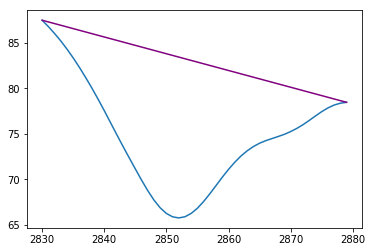

In [11]:
sample_x = Peak(2879,2830,"Sample B")
sample_x.data_setup()
sample_x.plot()
print("Peak area = " +  str(int(sample_x.area()))) 

### Step 2: Obtain names of samples to be analyzed from a CSV file

In [3]:
def samples_for_analysis():
    """Creates a list of samples for analysis pulling from a CSV file"""
    df = pd.read_csv("FTIR_sample_list.csv", header = None)
    samples_ = df.values.tolist()
    samples=  []
    for sample in samples_:
        samples.append(sample[0].replace("/",""))
    return samples

def rename(x):
    if x[0]=='1':
        y= x[0:2]+"/"+x[2:]
        return y
    elif x[0]=='0':
        y= x[0:2]+"/"+x[2:]
        return y
    else:
        return x

samples = samples_for_analysis()
lista_names = []
for item in samples:
    lista_names.append(item)
lista_names = pd.DataFrame(lista_names)
lista_names["ID"]=lista_names[0].apply(rename)
lista_names=lista_names.drop([0], axis=1)
lista_names.head()

,ID
0,Sample A
1,Sample B
2,Sample C
3,Sample D
4,Sample E


### Step 3: Define a list of wavenumber bands defining start and end point of each peak of interest:

In [4]:
peaks=[[3600,3100],[3100,2879],[2879,2830],[2745,2705],[1725,1680],[1680,1540],[1520,1395],[1395,1360],
      [1330,1280],[1272,1245],[1215,1207],[1180,1140],[1050,984],[910,840],[840,787],[770,736],
      [736,708]]

### Step 4: Run the analysis instantiating a class object for each sample and each peak of interest. Append the results to a list.

In [5]:
samples = samples_for_analysis()
lista = []
for item in samples:
    lista2=[]
    for peak in peaks:
        sample_x = Peak(peak[0],peak[1],item)
        sample_x.data_setup()
        lista2.append(sample_x.area())
    lista.append(lista2)
lista = pd.DataFrame(lista)

### Step 5: Organize the analyzed data and export to a CSV file named "FTIR_results"

In [6]:
#Create column names for the result table using the peak ranges:
peaks=[[3600,3100],[3100,2879],[2879,2830],[2745,2705],[1725,1680],[1680,1540],[1520,1395],[1395,1360],
      [1330,1280],[1272,1245],[1215,1207],[1180,1140],[1050,984],[910,840],[840,787],[770,736],
      [736,708]]

peak_names = []
for peak in peaks:
    peak_name=str(peak[0])+"-"+str(peak[1])+" cm-1, area"
    peak_names.append(peak_name)
lista.columns=peak_names


#Concatenate the list containing sample names with the data frame containing peak areas and export to csv
result=pd.concat([lista_names,lista], axis=1)
result.to_csv("FTIR_results.csv", index=None)

### Step 6 (Optional): Visualize the distribution of results for a selected peak:

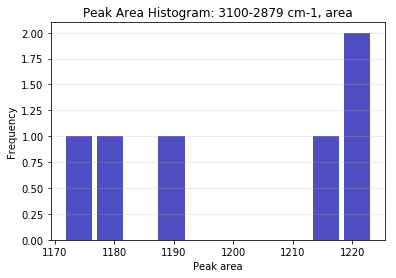

In [12]:
plt.xlabel("Peak area")
plt.ylabel("Frequency")
plt.grid(axis='y', alpha=0.3)
plt.title("Peak Area Histogram: 3100-2879 cm-1, area")
plt.hist(lista["3100-2879 cm-1, area"],color='#0504aa',alpha=0.7, rwidth=0.85)
plt.show()

### Step 7 (Optional): Display the results table:

In [15]:
result.head()

,ID,"3600-3100 cm-1, area","3100-2879 cm-1, area","2879-2830 cm-1, area","2745-2705 cm-1, area","1725-1680 cm-1, area","1680-1540 cm-1, area","1520-1395 cm-1, area","1395-1360 cm-1, area","1330-1280 cm-1, area","1272-1245 cm-1, area","1215-1207 cm-1, area","1180-1140 cm-1, area","1050-984 cm-1, area","910-840 cm-1, area","840-787 cm-1, area","770-736 cm-1, area","736-708 cm-1, area"
0,Sample A,0.05440,1188.767353,417.68,6.445625,4.383333,198.715929,838.30328,135.365429,20.5400,2.992778,0.175000,10.597875,78.080,79.865714,90.676981,25.223529,67.315
1,Sample B,26.82984,1181.289118,416.99,7.100000,3.653333,194.681250,821.08000,131.609000,20.5050,0.133889,0.034375,9.861250,66.955,83.339286,85.920566,31.850000,53.895
2,Sample C,34.56750,1221.348801,463.62,7.040000,2.828778,121.160286,797.68488,125.062857,15.9865,0.357407,0.080000,9.725000,78.720,92.476500,66.000755,24.114412,108.850
3,Sample D,5.94850,1171.419412,410.63,7.840000,7.696889,169.912500,817.94412,149.192000,18.4050,0.267778,0.047500,12.120000,61.110,101.784000,84.952642,38.055000,37.090
4,Sample E,159.45380,1223.393258,447.51,8.480000,1.883667,163.244286,897.46736,126.765000,22.9124,0.650000,0.075000,15.325000,166.015,94.725714,93.996415,29.600000,75.665
